# Adaptive Stochastic Frank-Wolfe:

This is a project for the subject Optimitzation for Data Science (UNIPD).

The work is based on Reddi et. al.’s Stochastic Frank-Wolfe algorithm (SFW) and Combettes et. al.’s AdaSVRF.

Authors: Shab Cesare Akira Pompeiano and Antoni Valls Cifre

# 1.  Algotithms
We present the algorithms first : SFW, AdaSFW and AdaSVRF.




## 1.1 Stochastic Frank-Wolfe (SFW)

In [1]:
import numpy as np
import time
import plotly.graph_objects as go

def ReLU(x):
    '''ReLU activation function'''
    return np.maximum(0,x)

def dReLU(x):
    '''Derivative of ReLU activation function'''
    return 1 * (x > 0)

def softmax(z):
    '''Softmax function for multi-class classification output'''
    z = z - np.max(z, axis=1, keepdims=True)
    z_out = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return z_out

class SFW_NN:
    def __init__(self, X_train, y_train, X_test, y_test, initfactor, batch_size=12, epochs=500):
        '''Initializes the network parameters'''
        self.start = time.time()
        self.input_data = X_train
        self.target_data = y_train
        self.test_data = X_test
        self.target_test =  y_test
        self.batch_size = batch_size
        self.epochs = epochs
        self.initfactor = initfactor

        self.loss_history = []
        self.accuracy_history = []

        #self.test_loss_history = []
        self.test_accuracy_history = []

        self.epoch_decimal = []
        self.cpu_time = []

        self.W1_values = []
        self.W2_values = []

        # Initialize weights and biases
        self.init_weights_and_biases()

    def plot_init_weights(self):

        ##### W1 #####

        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius1
        upper_boundary = self.Linf_radius1

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro', 'mo']
        for i in range(self.W1.T.shape[1]):
            plt.plot(self.W1.T[:, i], colors[i], label=f'Weights of Neuron {i+1}')


        # Create arrays with the same length as self.W1.T for the boundaries
        lower_boundary_array = np.full_like(self.W1.T, lower_boundary)
        upper_boundary_array = np.full_like(self.W1.T, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W1 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W1.T.min())
        ylim_max = max(upper_boundary.max() * 2, self.W1.T.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

        ##### W2 ####
        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius2
        upper_boundary = self.Linf_radius2

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro']  # list of colors for the three neurons
        for i in range(self.W2.shape[1]):
            plt.plot(self.W2[:, i], colors[i], label=f'Weights of Neuron {i+1}')


        # Create arrays with the same length as self.W2 for the boundaries
        lower_boundary_array = np.full_like(self.W2, lower_boundary)
        upper_boundary_array = np.full_like(self.W2, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W2 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W2.min())
        ylim_max = max(upper_boundary.max() * 2, self.W2.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

    def init_weights_and_biases(self):
        '''Initializes the network weights and biases randomly'''

        '''The Glorot (or Xavier) uniform initialization is a method to initialize the weights of the neural network.
        The weights are drawn from a distribution with zero mean and a specific variance.
        For the uniform distribution, the weights are drawn from a range [-limit, limit], where limit is
        sqrt(6 / (fan_in + fan_out)), with fan_in representing the number of input units in the weight tensor and fan_out is the number of output units.'''

        # Get the dimensions of the input, hidden, and output layers
        n_input = self.input_data.shape[1]
        n_hidden = 64
        n_output = self.target_data.shape[1]

        # Calculate the limit for the uniform distribution
        limit1 = np.sqrt(6. / (n_input + n_hidden))
        limit2 = np.sqrt(6. / (n_hidden + n_output))

        '''
        Calculating the expected L2 norm of this uniform distribution over the interval [-limit, limit] is equivalent to
        calculating the root mean square (RMS) of the uniform distribution, which can be obtained with the formula:

        RMS = sqrt((a^2 + b^2 + ab) / 3)

        where a and b represent the interval of the uniform distribution. So for Glorot uniform initialization, a is -limit and b is limit.
        Replacing a and b with their values, the expected L2 norm becomes:

        RMS = sqrt(((-limit)^2 + (limit)^2 + (-limit)*(limit)) / 3)
        = sqrt((2 * limit^2) / 3)

        So, the expected L2-norm of Glorot uniform initialized values would be sqrt((2 * limit^2) / 3), where limit is sqrt(6 / (fan_in + fan_out)).
        '''

        # Compute the expected L2 norm
        self.expected_l2_norm1 = np.sqrt((2 * limit1**2) / 3)
        self.expected_l2_norm2 = np.sqrt((2 * limit2**2) / 3)

        # Initialize the weights with values drawn from a uniform distribution with range [-limit1, limit1]
        self.W1 = np.random.uniform(-limit1, limit1, (n_input, n_hidden))
        self.W2 = np.random.uniform(-limit2, limit2, (n_hidden, n_output))

        '''
        Each layer is constrained into an L-infinity ball with L2-diameter equal to 2 * 'self.initfactor' times the expected
        L2-norm of the Glorot uniform initialized values
        '''
        # Compute the radius
        self.Linf_radius1 = self.initfactor * self.expected_l2_norm1
        self.Linf_radius2 = self.initfactor * self.expected_l2_norm2

        # Clip the weights to this radius
        self.W1 = np.clip(self.W1, -self.Linf_radius1, self.Linf_radius1)
        self.W2 = np.clip(self.W2, -self.Linf_radius2, self.Linf_radius2)

        # Save the initial weights
        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)

        print(" W1 radius", self.Linf_radius1)
        print(" W2 radius", self.Linf_radius2)


        '''
        This approach can be understood as an application of projected gradient descent, where the weights are first
        initialized and then projected onto the l∞-ball of the desired size.

        The l∞-ball constraint can help control the spread of values in the weights, which can be useful in preventing
        excessive weights values which might lead to problems like exploding gradients during training.'''

        # Initialize the bias as 0 or as really small value
        self.b1 = np.zeros(n_hidden)
        self.b2 = np.zeros(n_output)

        print("W1:",self.W1.shape)
        print("W2:",self.W2.shape)

        #self.plot_init_weights()

    def shuffle_data(self):
        '''Shuffles the input and target data in unison'''
        indices = np.arange(self.input_data.shape[0])
        np.random.shuffle(indices)
        self.input_data = self.input_data[indices]
        self.target_data = self.target_data[indices]

    def feedforward(self, batch_input, batch_target):
        '''Performs the forward pass through the network'''
        self.layer1_pre_activation = np.dot(batch_input, self.W1) + self.b1
        self.layer1_post_activation = ReLU(self.layer1_pre_activation)

        self.layer2_pre_activation = np.dot(self.layer1_post_activation, self.W2) + self.b2
        self.output = softmax(self.layer2_pre_activation)

        self.error = self.output - batch_target

    def compute_direction(self, g, radius):

        '''Computes the direction s using the Frank-Wolfe algorithm with Linf norm ball constraints.
        When the constrain is a polytope (e.g. a L-infinity ball), we know, by means of the fundamental theorem
        of linear programming that one of the vertices is solution of the linear program.
        It allows us to search for the optimal solution within the vertices, rather than exploring the entire feasible region
        '''
        s = np.zeros_like(g)
        for i in range(len(g)):
            if g[i] > 0:
                s[i] = -radius  # minimize in this dimension
            else:
                s[i] = radius  # maximize in this dimension
        return s

    def backpropagation(self, batch_input, epoch):
        '''Performs the backward pass through the network'''
        error_derivative = (1/self.batch_size) * self.error

        # Compute gradients for layer 2 (output layer) weights and biases
        dW2 = np.dot(self.layer1_post_activation.T, error_derivative)
        db2 = np.sum(error_derivative, axis=0)

        # Compute gradient for layer 1 weights and biases
        dcost_dz1 = np.dot(error_derivative, self.W2.T)
        dz1_da1 = dReLU(self.layer1_pre_activation)
        dcost_da1 = dcost_dz1 * dz1_da1
        dW1 = np.dot(batch_input.T, dcost_da1)
        db1 = np.sum(dcost_da1, axis=0)

        # Update weights and biases using the Frank-Wolfe algorithm
        self.s_W2 = self.compute_direction(dW2.flatten(), self.Linf_radius2)
        self.s_b2 = self.compute_direction(db2.flatten(), self.Linf_radius2)
        self.s_W1 = self.compute_direction(dW1.flatten(), self.Linf_radius1)
        self.s_b1 = self.compute_direction(db1.flatten(), self.Linf_radius1)

        alpha = 2 / (2 + epoch)  # Step size parameter

        self.W2 = self.W2 + alpha * (self.s_W2.reshape(self.W2.shape) - self.W2)
        self.b2 = self.b2 + alpha * (self.s_b2.reshape(self.b2.shape) - self.b2)
        self.W1 = self.W1 + alpha * (self.s_W1.reshape(self.W1.shape) - self.W1)
        self.b1 = self.b1 + alpha * (self.s_b1.reshape(self.b1.shape) - self.b1)


        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)


    def train(self):
        '''Trains the network using mini-batch gradient '''
        start_time = time.time()

        for epoch in range(self.epochs):
            epoch_loss = 0
            epoch_accuracy = 0

            for batch_index in range(self.input_data.shape[0] // self.batch_size - 1):
                # Shuffle the data at the beginning of each epoch
                self.shuffle_data()

                # Extract the current mini-batch from the input and target data
                start_index = batch_index * self.batch_size
                end_index = (batch_index + 1) * self.batch_size
                batch_input = self.input_data[start_index:end_index]
                batch_target = self.target_data[start_index:end_index]

                # Perform a forward pass through the network
                self.feedforward(batch_input, batch_target)

                # Perform a backward pass through the network (backpropagation)
                self.backpropagation(batch_input, epoch)

                # Update the total loss and accuracy for this epoch
                epoch_loss += np.mean(self.error ** 2)
                epoch_accuracy += np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(batch_target, axis=1)) / self.batch_size

                # Calculate training loss
                self.loss_history.append(np.mean(self.error ** 2))


                # Calculate accuracy for the test dataset
                self.feedforward(self.test_data, self.target_test)
                #self.test_loss_history.append(np.mean(self.error ** 2))

                correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
                total_predictions = self.test_data.shape[0]

                self.test_accuracy_history.append(correct_predictions * 100 / total_predictions)

                # Save epoch number and CPU time
                decimal = batch_index / (self.input_data.shape[0] // self.batch_size - 1)
                self.epoch_decimal.append(epoch + decimal)
                self.cpu_time.append(time.time() - start_time)


            # Add the average loss and accuracy for this epoch to the history
            self.accuracy_history.append(epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size))

            # Print the average loss and accuracy for this epoch
            print(f'Time {time.time() - self.start:.5f}s, Epoch {epoch + 1}: \
            Loss = {epoch_loss / (self.input_data.shape[0] // self.batch_size)},\
            Accuracy = {epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size)}%')


    def plot_learning_curves(self):
        '''Plots the learning curves for loss and accuracy over epochs'''
        #### Plot training accuracy curve for testing
        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot accuracy over epochs
        ax.plot(self.accuracy_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.set_title("Training Accuracy curve (to be removed)")

        plt.tight_layout()
        plt.show()


        #### Plot comprehensive curves
        from scipy.signal import savgol_filter

        # Create subplots
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))

        # Define the color for the curves
        curve_color = 'blue'

        # Plot loss over epochs
        ax[0, 0].plot(self.epoch_decimal, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        smoothed_loss = savgol_filter(self.loss_history, window_length=11, polyorder=3)
        ax[0, 0].plot(self.epoch_decimal, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 0].set_ylabel("Training")

        # Plot loss over CPU time
        ax[0, 1].plot(self.cpu_time, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        ax[0, 1].plot(self.cpu_time, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 1].set_xlabel("CPU Time")

        # Plot accuracy over epochs
        ax[1, 0].plot(self.epoch_decimal, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        smoothed_accuracy = savgol_filter(self.test_accuracy_history, window_length=11, polyorder=3)
        ax[1, 0].plot(self.epoch_decimal, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 0].set_xlabel("Epoch")
        ax[1, 0].set_ylabel("Test")

        # Plot accuracy over CPU time
        ax[1, 1].plot(self.cpu_time, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        ax[1, 1].plot(self.cpu_time, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 1].set_xlabel("CPU Time")

        plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

        ax[0, 0].set_title("Loss over Epoch")
        ax[0, 1].set_title("Loss over CPU Time")
        ax[1, 0].set_title("Accuracy over Epoch")
        ax[1, 1].set_title("Accuracy over CPU Time")

        plt.suptitle("Comprehensive Training and Test learning curves", fontsize=16)

        plt.show()


    def plot_2D_update(self):
        # extract the first two weights of the first neuron of W1 for each update
        W1_first_two_weights = [weights[:2] for weights in self.W1_values]
        W1_x = [weights[0] for weights in W1_first_two_weights]
        W1_y = [weights[1] for weights in W1_first_two_weights]

        # do the same for W2
        W2_first_two_weights = [weights[:2] for weights in self.W2_values]
        W2_x = [weights[0] for weights in W2_first_two_weights]
        W2_y = [weights[1] for weights in W2_first_two_weights]

        # create L inf ball (a square in 2D)
        x_1 = np.array([self.Linf_radius1, self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1])
        y_1 = np.array([self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1, self.Linf_radius1])

        x_2 = np.array([self.Linf_radius2, self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2])
        y_2 = np.array([self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2, self.Linf_radius2])

        ball_trace_1 = go.Scatter(x=x_1, y=y_1, mode='lines', name='L inf ball')
        ball_trace_2 = go.Scatter(x=x_2, y=y_2, mode='lines', name='L inf ball')

        # create the plots
        trace1 = go.Scatter(x=W1_x, y=W1_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W1_x))), name='W1 weights')
        trace2 = go.Scatter(x=W2_x, y=W2_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W2_x))), name='W2 weights')


        layout1 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W1 (between input and hidden layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))
        layout2 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W2 (between hidden and output layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))

        # create a Figure for W1 and add traces to it
        fig1 = go.Figure(data=[trace1, ball_trace_1], layout=layout1)
        fig1.update_layout(showlegend=False)
        # plot the figure
        fig1.show()

        # create a Figure for W2 and add traces to it
        fig2 = go.Figure(data=[trace2, ball_trace_2], layout=layout2)
        fig2.update_layout(showlegend=False)
        # plot the figure
        fig2.show()



    def test(self):
        '''Tests the trained network using test data'''
        # Use the test input and target data to perform a forward pass through the network
        self.feedforward(self.test_data, self.target_test)
        #print(self.output)

        # Compute the accuracy by comparing the output of the network to the target data
        correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
        total_predictions = self.test_data.shape[0]
        accuracy = correct_predictions / total_predictions

        print(f'Accuracy: {100 * accuracy}%')

## 1.2 Adaptive Stochastic Frank-Wolfe (AdaSFW)

This one is not a mandatory algorithm for our project.

In [2]:
import numpy as np
import time
import plotly.graph_objects as go

def ReLU(x):
    '''ReLU activation function'''
    return np.maximum(0,x)

def dReLU(x):
    '''Derivative of ReLU activation function'''
    return 1 * (x > 0)

def softmax(z):
    '''Softmax function for multi-class classification output'''
    z = z - np.max(z, axis=1, keepdims=True)
    z_out = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return z_out

class AdaSFW_NN:
    def __init__(self, X_train, y_train, X_test, y_test, initfactor, nu = 10**(-1/2), batch_size=12, epochs=20, K = 5, delta = 1e-7):
        '''Initializes the network parameters'''
        self.start = time.time()
        self.input_data = X_train
        self.target_data = y_train
        self.test_data = X_test
        self.target_test =  y_test
        self.batch_size = batch_size
        self.epochs = epochs
        self.K = K
        self.delta = delta
        self.nu = nu
        self.initfactor = initfactor

        self.loss_history = []
        self.accuracy_history = []

        #self.test_loss_history = []
        self.test_accuracy_history = []

        self.epoch_decimal = []
        self.cpu_time = []

        self.W1_values = []
        self.W2_values = []

        # Initialize weights and biases
        self.init_weights_and_biases()

         # Initialize the H matrix
        self.init_H()


    def plot_init_weights(self):

        ##### W1 #####

        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius1
        upper_boundary = self.Linf_radius1

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro', 'mo']  # list of colors for the three neurons
        for i in range(self.W1.T.shape[1]):
            plt.plot(self.W1.T[:, i], colors[i], label=f'Weights of Neuron {i+1}')


        # Create arrays with the same length as self.W1.T for the boundaries
        lower_boundary_array = np.full_like(self.W1.T, lower_boundary)
        upper_boundary_array = np.full_like(self.W1.T, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W1 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W1.T.min())
        ylim_max = max(upper_boundary.max() * 2, self.W1.T.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

        ##### W2 ####
        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius2
        upper_boundary = self.Linf_radius2

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro']  # list of colors for the three neurons
        for i in range(self.W2.shape[1]):
            plt.plot(self.W2[:, i], colors[i], label=f'Weights of Neuron {i+1}')

        # Create arrays with the same length as self.W2 for the boundaries
        lower_boundary_array = np.full_like(self.W2, lower_boundary)
        upper_boundary_array = np.full_like(self.W2, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W2 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W2.min())
        ylim_max = max(upper_boundary.max() * 2, self.W2.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

    def init_weights_and_biases(self):
        '''Initializes the network weights and biases randomly'''

        '''The Glorot (or Xavier) uniform initialization is a method to initialize the weights of the neural network.
        The weights are drawn from a distribution with zero mean and a specific variance.
        For the uniform distribution, the weights are drawn from a range [-limit, limit], where limit is
        sqrt(6 / (fan_in + fan_out)), with fan_in representing the number of input units in the weight tensor and fan_out is the number of output units.'''

        # Step 1: Get the dimensions of the input, hidden, and output layers
        n_input = self.input_data.shape[1]
        n_hidden = 64
        n_output = self.target_data.shape[1]

        # Calculate the limit for the uniform distribution
        limit1 = np.sqrt(6. / (n_input + n_hidden))
        limit2 = np.sqrt(6. / (n_hidden + n_output))

        '''
        Calculating the expected L2 norm of this uniform distribution over the interval [-limit, limit] is equivalent to
        calculating the root mean square (RMS) of the uniform distribution, which can be obtained with the formula:

        RMS = sqrt((a^2 + b^2 + ab) / 3)

        where a and b represent the interval of the uniform distribution. So for Glorot uniform initialization, a is -limit and b is limit.
        Replacing a and b with their values, the expected L2 norm becomes:

        RMS = sqrt(((-limit)^2 + (limit)^2 + (-limit)*(limit)) / 3)
        = sqrt((2 * limit^2) / 3)

        So, the expected L2-norm of Glorot uniform initialized values would be sqrt((2 * limit^2) / 3), where limit is sqrt(6 / (fan_in + fan_out)).
        '''
        # Compute the expected L2 norm
        self.expected_l2_norm1 = np.sqrt((2 * limit1**2) / 3)
        self.expected_l2_norm2 = np.sqrt((2 * limit2**2) / 3)

        # Initialize the weights with values drawn from a uniform distribution with range [-limit1, limit1]
        self.W1 = np.random.uniform(-limit1, limit1, (n_input, n_hidden))
        self.W2 = np.random.uniform(-limit2, limit2, (n_hidden, n_output))

        '''
        Each layer is constrained into an L-infinity ball with L2-diameter equal to 2 * 'self.initfactor' times the expected
        L2-norm of the Glorot uniform initialized values
        '''

        # Compute the radius
        self.Linf_radius1 = self.initfactor * self.expected_l2_norm1
        self.Linf_radius2 = self.initfactor  * self.expected_l2_norm2

        # Clip the weights to this radius
        self.W1 = np.clip(self.W1, -self.Linf_radius1, self.Linf_radius1)
        self.W2 = np.clip(self.W2, -self.Linf_radius2, self.Linf_radius2)

        # Save the initial weights
        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)

        print(" W1 radius", self.Linf_radius1)
        print(" W2 radius", self.Linf_radius2)

        '''
        This approach can be understood as an application of projected gradient descent, where the weights are first
         initialized and then projected onto the l∞-ball of the desired size.

        The l∞-ball constraint can help control the spread of values in the weights, which can be useful in preventing
         excessive weights values which might lead to problems like exploding gradients during training.'''

        # Init the bias as 0 or as really small value
        self.b1 = np.zeros(n_hidden)
        self.b2 = np.zeros(n_output)

        print("W1:",self.W1.shape)
        print("W2:",self.W2.shape)

        #self.plot_init_weights()

    def init_H(self):
        '''Initializes the H diagonal matrixes'''
        # They are square diagonal matrices, but we define them as vectors formed by the diagonal elements
        self.H_W1 = np.zeros(self.W1.size)
        self.H_W2 = np.zeros(self.W2.size)
        self.H_b1 = np.zeros(self.b1.size)
        self.H_b2 = np.zeros(self.b2.size)

        # Initialize to zero the sum of the historical square gradients
        self.sum_W1 = np.zeros(self.W1.size)
        self.sum_W2 = np.zeros(self.W2.size)
        self.sum_b1 = np.zeros(self.b1.size)
        self.sum_b2 = np.zeros(self.b2.size)

    def shuffle_data(self):
        '''Shuffles the input and target data in unison'''
        indices = np.arange(self.input_data.shape[0])
        np.random.shuffle(indices)
        self.input_data = self.input_data[indices]
        self.target_data = self.target_data[indices]

    def feedforward(self, batch_input, batch_target):
        '''Performs the forward pass through the network'''
        self.layer1_pre_activation = np.dot(batch_input, self.W1) + self.b1
        self.layer1_post_activation = ReLU(self.layer1_pre_activation)

        self.layer2_pre_activation = np.dot(self.layer1_post_activation, self.W2) + self.b2
        self.output = softmax(self.layer2_pre_activation)

        self.error = self.output - batch_target

    def update_H(self, H, sum_g, epoch):
        ''' Updates the H matrix recurrently'''
        # Get the min and max eigenvector of the previous H
        Hmin = np.min(H)
        Hmax = np.max(H)

        # Compute the new H matrix
        H = [self.delta] * H.size + np.sqrt(sum_g)

        # Clip the entries (but not in the first epoch)
        if epoch != 0:
          H = np.clip(H, Hmin, Hmax)

        return H

    def compute_direction(self, g, radius):
        '''Computes the direction s using the Frank-Wolfe algorithm with Linf norm ball constraints'''
        s = np.zeros_like(g)
        for i in range(len(g)):
            if g[i] > 0:
                s[i] = -radius  # minimize in this dimension
            else:
                s[i] = radius  # maximize in this dimension
        return s

    def update_weights(self, w, g, H, radius):
        '''FW K times to update the parameters using adaptative gradients (Lines 4-10 of Templete 3)
        w: actual weights
        g: actual gradients
        H: actual H matrix'''
        y = w # (line 4)

        for k in range(self.K):
          # Compute the gradient of Q (line 6)
          gQ = g + np.multiply(H, y - w)/self.nu

          # Compute the direction of minimum linear approximation (FW) (line 7)
          v = self.compute_direction(gQ, radius)

          # Compute the stepsize (line 8)
          gamma = 0.01

          # Update y value (line 9)
          y = y + gamma * (v - y)

        return y

    def backpropagation(self, batch_input, epoch):
        '''Performs the backward pass through the network'''
        error_derivative = (1/self.batch_size) * self.error

        # Compute gradients for layer 2 (output layer) weights and biases
        dW2 = np.dot(self.layer1_post_activation.T, error_derivative)
        db2 = np.sum(error_derivative, axis=0)

        # Compute gradient for layer 1 weights and biases
        dcost_dz1 = np.dot(error_derivative, self.W2.T)
        dz1_da1 = dReLU(self.layer1_pre_activation)
        dcost_da1 = dcost_dz1 * dz1_da1
        dW1 = np.dot(batch_input.T, dcost_da1)
        db1 = np.sum(dcost_da1, axis=0)

        # Compute the sum of the historical square gradients
        self.sum_W2 = self.sum_W2 + np.square(dW2.flatten())
        self.sum_b2 = self.sum_b2 + np.square(db2.flatten())
        self.sum_W1 = self.sum_W1 + np.square(dW1.flatten())
        self.sum_b1 = self.sum_b1 + np.square(db1.flatten())

        # Update the matrix H
        self.H_W2 = self.update_H(self.H_W2, self.sum_W2, epoch)
        self.H_b2 = self.update_H(self.H_b2, self.sum_b2, epoch)
        self.H_W1 = self.update_H(self.H_W1, self.sum_W1, epoch)
        self.H_b1 = self.update_H(self.H_b1, self.sum_b1, epoch)


        # Update the weights and bias (Lines 4-10 in Templete 3)
        self.W2 = self.update_weights(self.W2.flatten(), dW2.flatten(), self.H_W2, self.Linf_radius2).reshape(self.W2.shape)
        self.b2 = self.update_weights(self.b2.flatten(), db2.flatten(), self.H_b2, self.Linf_radius2).reshape(self.b2.shape)
        self.W1 = self.update_weights(self.W1.flatten(), dW1.flatten(), self.H_W1, self.Linf_radius1).reshape(self.W1.shape)
        self.b1 = self.update_weights(self.b1.flatten(), db1.flatten(), self.H_b1, self.Linf_radius1).reshape(self.b1.shape)

        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)

    def train(self):
        '''Trains the network using mini-batch gradient '''
        start_time = time.time()

        for epoch in range(self.epochs):
            epoch_loss = 0
            epoch_accuracy = 0

            for batch_index in range(self.input_data.shape[0] // self.batch_size - 1):
                # Shuffle the data at the beginning of each epoch
                self.shuffle_data()

                # Extract the current mini-batch from the input and target data
                start_index = batch_index * self.batch_size
                end_index = (batch_index + 1) * self.batch_size
                batch_input = self.input_data[start_index:end_index]
                batch_target = self.target_data[start_index:end_index]

                # Perform a forward pass through the network
                self.feedforward(batch_input, batch_target)

                # Perform a backward pass through the network (backpropagation)
                self.backpropagation(batch_input, epoch)

                # Update the total loss and accuracy for this epoch
                epoch_loss += np.mean(self.error ** 2)
                epoch_accuracy += np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(batch_target, axis=1)) / self.batch_size

                # Calculate training loss
                self.loss_history.append(np.mean(self.error ** 2))


                # Calculate accuracy for the test dataset
                self.feedforward(self.test_data, self.target_test)
                #self.test_loss_history.append(np.mean(self.error ** 2))

                correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
                total_predictions = self.test_data.shape[0]

                self.test_accuracy_history.append(correct_predictions * 100 / total_predictions)

                # Save epoch number and CPU time
                decimal = batch_index / (self.input_data.shape[0] // self.batch_size - 1)
                self.epoch_decimal.append(epoch + decimal)
                self.cpu_time.append(time.time() - start_time)


            # Add the average loss and accuracy for this epoch to the history
            self.accuracy_history.append(epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size))

            # Print the average loss and accuracy for this epoch
            print(f'Time {time.time() - self.start:.5f}s, Epoch {epoch + 1}: \
            Loss = {epoch_loss / (self.input_data.shape[0] // self.batch_size)},\
            Accuracy = {epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size)}%')

    def plot_learning_curves(self):
        '''Plots the learning curves for loss and accuracy over epochs'''
        #### Plot training accuracy curve for testing
        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot accuracy over epochs
        ax.plot(self.accuracy_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.set_title("Training Accuracy curve (to be removed)")

        plt.tight_layout()
        plt.show()


        #### Plot comprehensive curves
        from scipy.signal import savgol_filter

        # Create subplots
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))

        # Define the color for the curves
        curve_color = 'blue'

        # Plot loss over epochs
        ax[0, 0].plot(self.epoch_decimal, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        smoothed_loss = savgol_filter(self.loss_history, window_length=11, polyorder=3)
        ax[0, 0].plot(self.epoch_decimal, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 0].set_ylabel("Training")

        # Plot loss over CPU time
        ax[0, 1].plot(self.cpu_time, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        ax[0, 1].plot(self.cpu_time, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 1].set_xlabel("CPU Time")

        # Plot accuracy over epochs
        ax[1, 0].plot(self.epoch_decimal, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        smoothed_accuracy = savgol_filter(self.test_accuracy_history, window_length=11, polyorder=3)
        ax[1, 0].plot(self.epoch_decimal, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 0].set_xlabel("Epoch")
        ax[1, 0].set_ylabel("Test")

        # Plot accuracy over CPU time
        ax[1, 1].plot(self.cpu_time, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        ax[1, 1].plot(self.cpu_time, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 1].set_xlabel("CPU Time")

        plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

        ax[0, 0].set_title("Loss over Epoch")
        ax[0, 1].set_title("Loss over CPU Time")
        ax[1, 0].set_title("Accuracy over Epoch")
        ax[1, 1].set_title("Accuracy over CPU Time")

        plt.suptitle("Comprehensive Training and Test learning curves", fontsize=16)

        plt.show()

    def plot_2D_update(self):
        # extract the first two weights of the first neuron of W1 for each update
        W1_first_two_weights = [weights[:2] for weights in self.W1_values]
        W1_x = [weights[0] for weights in W1_first_two_weights]
        W1_y = [weights[1] for weights in W1_first_two_weights]

        # do the same for W2
        W2_first_two_weights = [weights[:2] for weights in self.W2_values]
        W2_x = [weights[0] for weights in W2_first_two_weights]
        W2_y = [weights[1] for weights in W2_first_two_weights]

        # create L inf ball (a square in 2D)
        x_1 = np.array([self.Linf_radius1, self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1])
        y_1 = np.array([self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1, self.Linf_radius1])

        x_2 = np.array([self.Linf_radius2, self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2])
        y_2 = np.array([self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2, self.Linf_radius2])

        ball_trace_1 = go.Scatter(x=x_1, y=y_1, mode='lines', name='L inf ball')
        ball_trace_2 = go.Scatter(x=x_2, y=y_2, mode='lines', name='L inf ball')

        # create the plots
        trace1 = go.Scatter(x=W1_x, y=W1_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W1_x))), name='W1 weights')
        trace2 = go.Scatter(x=W2_x, y=W2_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W2_x))), name='W2 weights')

        layout1 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W1 (between input and hidden layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))
        layout2 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W2 (between hidden and output layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))

        # create a Figure for W1 and add traces to it
        fig1 = go.Figure(data=[trace1, ball_trace_1], layout=layout1)
        fig1.update_layout(showlegend=False)
        # plot the figure
        fig1.show()

        # create a Figure for W2 and add traces to it
        fig2 = go.Figure(data=[trace2, ball_trace_2], layout=layout2)
        fig2.update_layout(showlegend=False)
        # plot the figure
        fig2.show()

    def test(self):
        '''Tests the trained network using test data'''
        # Use the test input and target data to perform a forward pass through the network
        self.feedforward(self.test_data, self.target_test)
        #print(self.output)

        # Compute the accuracy by comparing the output of the network to the target data
        correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
        print(correct_predictions)
        total_predictions = self.test_data.shape[0]
        accuracy = correct_predictions / total_predictions

        print(f'Accuracy: {100 * accuracy}%')


## 1.3 Adaptive Stochastic Variance Reducted Frank-Wolfe (AdaSVRF)

In [3]:
import numpy as np
import time
import plotly.graph_objects as go

def ReLU(x):
    '''ReLU activation function'''
    return np.maximum(0,x)

def dReLU(x):
    '''Derivative of ReLU activation function'''
    return 1 * (x > 0)


def softmax(z):
    '''Softmax function for multi-class classification output'''
    z = z - np.max(z, axis=1, keepdims=True)
    z_out = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return z_out

class AdaSVRF_NN:
    def __init__(self, X_train, y_train, X_test, y_test, initfactor, nu, K, batch_size=12, epochs=20, delta = 1e-7):
        '''Initializes the network parameters'''
        self.start = time.time()
        self.input_data = X_train
        self.target_data = y_train
        self.test_data = X_test
        self.target_test =  y_test
        self.batch_size = batch_size
        self.epochs = epochs
        self.K = K
        self.delta = delta
        self.nu = nu
        self.initfactor = initfactor

        self.loss_history = []
        self.accuracy_history = []

        #self.test_loss_history = []
        self.test_accuracy_history = []

        self.epoch_decimal = []
        self.cpu_time = []

        self.W1_values = []
        self.W2_values = []

        # Initialize weights and biases
        self.init_weights_and_biases()

         # Initialize the H matrix
        self.init_H()


    def plot_init_weights(self):

        ##### W1 #####

        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius1
        upper_boundary = self.Linf_radius1

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro', 'mo']  # list of colors for the three neurons
        for i in range(self.W1.T.shape[1]):
            plt.plot(self.W1.T[:, i], colors[i], label=f'Weights of Neuron {i+1}')


        # Create arrays with the same length as self.W1.T for the boundaries
        lower_boundary_array = np.full_like(self.W1.T, lower_boundary)
        upper_boundary_array = np.full_like(self.W1.T, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W1 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W1.T.min())
        ylim_max = max(upper_boundary.max() * 2, self.W1.T.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

        ##### W2 ####
        # Define the boundaries of the l∞-ball
        lower_boundary = -self.Linf_radius2
        upper_boundary = self.Linf_radius2

        # Plot the weights and the boundaries of the l∞-ball
        plt.figure(figsize=(10, 6))

        colors = ['bo', 'go', 'ro']  # list of colors for the three neurons
        for i in range(self.W2.shape[1]):
            plt.plot(self.W2[:, i], colors[i], label=f'Weights of Neuron {i+1}')

        # Create arrays with the same length as self.W2 for the boundaries
        lower_boundary_array = np.full_like(self.W2, lower_boundary)
        upper_boundary_array = np.full_like(self.W2, upper_boundary)

        plt.plot(lower_boundary_array[0], 'k--', label='Lower boundary')
        plt.plot(upper_boundary_array[0], 'k--', label='Upper boundary')
        plt.title('W2 weights and l∞-Ball constraint')
        plt.xlabel('Weights index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

        # Set the Y-axis limits to show the upper and lower boundaries
        ylim_min = min(lower_boundary.min() * 2, self.W2.min())
        ylim_max = max(upper_boundary.max() * 2, self.W2.max())
        plt.ylim(ylim_min, ylim_max)

        plt.show()

    def init_weights_and_biases(self):
        '''Initializes the network weights and biases randomly'''

        '''The Glorot (or Xavier) uniform initialization is a method to initialize the weights of the neural network.
        The weights are drawn from a distribution with zero mean and a specific variance.
        For the uniform distribution, the weights are drawn from a range [-limit, limit], where limit is
        sqrt(6 / (fan_in + fan_out)), with fan_in representing the number of input units in the weight tensor and fan_out is the number of output units.'''

        # Get the dimensions of the input, hidden, and output layers
        n_input = self.input_data.shape[1]
        n_hidden = 64
        n_output = self.target_data.shape[1]

        # Calculate the limit for the uniform distribution
        limit1 = np.sqrt(6. / (n_input + n_hidden))
        limit2 = np.sqrt(6. / (n_hidden + n_output))

        '''
        Calculating the expected L2 norm of this uniform distribution over the interval [-limit, limit] is equivalent to
        calculating the root mean square (RMS) of the uniform distribution, which can be obtained with the formula:

        RMS = sqrt((a^2 + b^2 + ab) / 3)

        where a and b represent the interval of the uniform distribution. So for Glorot uniform initialization, a is -limit and b is limit.
        Replacing a and b with their values, the expected L2 norm becomes:

        RMS = sqrt(((-limit)^2 + (limit)^2 + (-limit)*(limit)) / 3)
        = sqrt((2 * limit^2) / 3)

        So, the expected L2-norm of Glorot uniform initialized values would be sqrt((2 * limit^2) / 3), where limit is sqrt(6 / (fan_in + fan_out)).
        '''
        # Compute the expected L2 norm
        self.expected_l2_norm1 = np.sqrt((2 * limit1**2) / 3)
        self.expected_l2_norm2 = np.sqrt((2 * limit2**2) / 3)

        # Initialize the weights with values drawn from a uniform distribution with range [-limit1, limit1]
        self.W1 = np.random.uniform(-limit1, limit1, (n_input, n_hidden))
        self.W2 = np.random.uniform(-limit2, limit2, (n_hidden, n_output))

        '''
        Each layer is constrained into an L-infinity ball with L2-diameter equal to 2 * 'self.initfactor' times the expected
        L2-norm of the Glorot uniform initialized values
        '''

        # Compute the radius
        self.Linf_radius1 = self.initfactor * self.expected_l2_norm1
        self.Linf_radius2 = self.initfactor * self.expected_l2_norm2

        # Clip the weights to this radius
        self.W1 = np.clip(self.W1, -self.Linf_radius1, self.Linf_radius1)
        self.W2 = np.clip(self.W2, -self.Linf_radius2, self.Linf_radius2)

        # Save the initial weights
        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)

        print(" W1 radius", self.Linf_radius1)
        print(" W2 radius", self.Linf_radius2)

        '''
        This approach can be understood as an application of projected gradient descent, where the weights are first
         initialized and then projected onto the l∞-ball of the desired size.

        The l∞-ball constraint can help control the spread of values in the weights, which can be useful in preventing
         excessive weights values which might lead to problems like exploding gradients during training.'''

        # Init the bias as 0 or as really small value
        self.b1 = np.zeros(n_hidden)
        self.b2 = np.zeros(n_output)

        print("W1:",self.W1.shape)
        print("W2:",self.W2.shape)

        #self.plot_init_weights()

    def init_H(self):
        '''Initializes the H diagonal matrixes'''
        # They are square diagonal matrices, but we define them as vectors formed by the diagonal elements
        self.H_W1 = np.zeros(self.W1.size)
        self.H_W2 = np.zeros(self.W2.size)
        self.H_b1 = np.zeros(self.b1.size)
        self.H_b2 = np.zeros(self.b2.size)

        # Initialize to zero the sum of the historical square gradients
        self.sum_W1 = np.zeros(self.W1.size)
        self.sum_W2 = np.zeros(self.W2.size)
        self.sum_b1 = np.zeros(self.b1.size)
        self.sum_b2 = np.zeros(self.b2.size)

    def shuffle_data(self):
        '''Shuffles the input and target data in unison.'''
        indices = np.arange(self.input_data.shape[0])
        np.random.shuffle(indices)
        self.input_data = self.input_data[indices]
        self.target_data = self.target_data[indices]

    def update_H(self, H, sum_g, epoch):
        ''' Updates the H matrix recurrently'''
        # Get the min and max eigenvector of the previous H
        Hmin = np.min(H)
        Hmax = np.max(H)

        # Compute the new H matrix
        H = [self.delta] * H.size + np.sqrt(sum_g)

        # Clip the entries (but not in the first epoch)
        if epoch != 0:
          H = np.clip(H, Hmin, Hmax)

        return H

    def compute_direction(self, g, radius):
        '''Computes the direction s using the Frank-Wolfe algorithm with Linf norm ball constraints'''
        s = np.zeros_like(g)
        for i in range(len(g)):
            if g[i] > 0:
                s[i] = -radius  # minimize in this dimension
            else:
                s[i] = radius  # maximize in this dimension
        return s

    def update_weights(self, w, g, H, radius):
        '''FW K times to update the parameters using adaptative gradients (Lines 4-10 of Templete 3)
        w: actual weights
        g: actual gradients
        H: actual H matrix'''
        y = w # (line 4)

        for k in range(self.K):
          # Compute the gradient of Q (line 6)
          gQ = g + np.multiply(H, y - w)/self.nu

          # Compute the direction of minimum linear approximation (FW) (line 7)
          v = self.compute_direction(gQ, radius)

          # Compute the stepsize (line 8)
          gamma = 0.01 # this should be (2/2 + k) but for the IRIS dataset this works better

          # Update y value (line 9)
          y = y + gamma * (v - y)

        return y

    def feedforward(self, batch_input, batch_target, snapshot):
        '''Performs the forward pass through the network'''
        if snapshot == False:
          self.layer1_pre_activation = np.dot(batch_input, self.W1) + self.b1
          self.layer1_post_activation = ReLU(self.layer1_pre_activation)

          self.layer2_pre_activation = np.dot(self.layer1_post_activation, self.W2) + self.b2
          self.output = softmax(self.layer2_pre_activation)

          self.error = self.output - batch_target

        else: # Uses the snapshot weights (use when not in snapshot time)
          self.snapshot_layer1_pre_activation = np.dot(batch_input, self.snapshot_W1) + self.snapshot_b1
          self.snapshot_layer1_post_activation = ReLU(self.snapshot_layer1_pre_activation)

          self.snapshot_layer2_pre_activation = np.dot(self.snapshot_layer1_post_activation, self.snapshot_W2) + self.snapshot_b2
          self.snapshot_output = softmax(self.snapshot_layer2_pre_activation)

          self.snapshot_error = self.snapshot_output - batch_target

    def backpropagation(self, batch_input, epoch, snapshot):
        '''Performs the backward pass through the network'''
        error_derivative = (1/self.batch_size) * self.error

        # Compute gradients for layer 2 (output layer) weights and biases
        dW2 = np.dot(self.layer1_post_activation.T, error_derivative)
        db2 = np.sum(error_derivative, axis=0)

        # Compute gradient for layer 1 weights and biases
        dcost_dz1 = np.dot(error_derivative, self.W2.T)
        dz1_da1 = dReLU(self.layer1_pre_activation)
        dcost_da1 = dcost_dz1 * dz1_da1
        dW1 = np.dot(batch_input.T, dcost_da1)
        db1 = np.sum(dcost_da1, axis=0)

        # When there it is not snapshot time we apply variance reduction
        if snapshot == False:

          # Compute the gradients using the last snapshot weights
          error_derivative = (1/self.batch_size) * self.snapshot_error

          snapshot_dW2 = np.dot(self.snapshot_layer1_post_activation.T, error_derivative)
          snapshot_db2 = np.sum(error_derivative, axis=0)

          dcost_dz1 = np.dot(error_derivative, self.snapshot_W2.T)
          dz1_da1 = dReLU(self.snapshot_layer1_pre_activation)
          dcost_da1 = dcost_dz1 * dz1_da1
          snapshot_dW1 = np.dot(batch_input.T, dcost_da1)
          snapshot_db1 = np.sum(dcost_da1, axis=0)

          # Apply variance reduction (Line 8 of Algorithm 5)
          dW2 = (snapshot_dW2 + np.sum(dW2 - snapshot_dW2)/ self.batch_size)
          db2 = (snapshot_db2 + np.sum(db2 - snapshot_db2)/ self.batch_size)
          dW1 = (snapshot_dW1 + np.sum(dW1 - snapshot_dW1)/ self.batch_size)
          db1= (snapshot_db1 + np.sum(db1 - snapshot_db1)/ self.batch_size)

        # Compute the sum of the historical square gradients
        self.sum_W2 = self.sum_W2 + np.square(dW2.flatten())
        self.sum_b2 = self.sum_b2 + np.square(db2.flatten())
        self.sum_W1 = self.sum_W1 + np.square(dW1.flatten())
        self.sum_b1 = self.sum_b1 + np.square(db1.flatten())

        # Update the matrix H
        self.H_W2 = self.update_H(self.H_W2, self.sum_W2, epoch)
        self.H_b2 = self.update_H(self.H_b2, self.sum_b2, epoch)
        self.H_W1 = self.update_H(self.H_W1, self.sum_W1, epoch)
        self.H_b1 = self.update_H(self.H_b1, self.sum_b1, epoch)


        # Update the weights and bias (Lines 4-10 in Templete 3)
        self.W2 = self.update_weights(self.W2.flatten(), dW2.flatten(), self.H_W2, self.Linf_radius2).reshape(self.W2.shape)
        self.b2 = self.update_weights(self.b2.flatten(), db2.flatten(), self.H_b2, self.Linf_radius2).reshape(self.b2.shape)
        self.W1 = self.update_weights(self.W1.flatten(), dW1.flatten(), self.H_W1, self.Linf_radius1).reshape(self.W1.shape)
        self.b1 = self.update_weights(self.b1.flatten(), db1.flatten(), self.H_b1, self.Linf_radius1).reshape(self.b1.shape)

        self.W1_values.append(self.W1[:, 0].copy())  # storing the weights of the first neuron of the hidden layer (R4 vector)
        self.W2_values.append(self.W2[0, :].copy().T)  # storing the weights from the first neuron of the hidden layer to output layer (R3 vector)


    def train(self):
        '''Trains the network using mini-batch gradient '''
        start_time = time.time()

        for epoch in range(self.epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            k = 0

            for batch_index in range(self.input_data.shape[0] // self.batch_size - 1): # 'batch_index' is 't' on (Algorithm 5)

                snapshot_k = 2**k - 1 # Next snapshot time
                if batch_index == snapshot_k:
                  ''' If it is snapshot time we compute and use the batch gradient'''
                  k += 1
                  self.batch_input = self.input_data
                  self.batch_target = self.target_data

                  # Update the snapshot weights
                  self.snapshot_W2 = self.W2
                  self.snapshot_b2 = self.b2
                  self.snapshot_W1 = self.W1
                  self.snapshot_b1 = self.b1

                  # Perform a forward pass through the network
                  self.feedforward(self.batch_input, self.batch_target, snapshot = False)

                  # Perform a backward pass through the network (backpropagation)
                  self.backpropagation(self.batch_input, epoch, snapshot = True)

                  # Update the total loss and accuracy for this epoch
                  epoch_loss += np.mean(self.error ** 2)
                  epoch_accuracy += np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.batch_target, axis=1)) / self.input_data.shape[0]

                  # Calculate training loss
                  self.loss_history.append(np.mean(self.error ** 2))

                  # Calculate accuracy for the test dataset
                  self.feedforward(self.test_data, self.target_test, snapshot = False)
                  #self.test_loss_history.append(np.mean(self.error ** 2))

                  correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
                  total_predictions = self.test_data.shape[0]

                  self.test_accuracy_history.append(correct_predictions * 100 / total_predictions)

                  # Save epoch number and CPU time
                  decimal = batch_index / (self.input_data.shape[0] // self.batch_size - 1)
                  self.epoch_decimal.append(epoch + decimal)
                  self.cpu_time.append(time.time() - start_time)

                else:
                  ''' If it is not snapshot time we apply variance reduction'''

                  # Shuffle the data
                  self.shuffle_data()

                  # Extract the current mini-batch from the input and target data
                  start_index = batch_index * self.batch_size
                  end_index = (batch_index + 1) * self.batch_size
                  batch_input = self.input_data[:self.batch_size]
                  batch_target = self.target_data[:self.batch_size]

                  # Perform a forward pass through the network USING THE SNAPSHOT WEIGHTS
                  self.feedforward(batch_input, batch_target, snapshot = True) # We get the snapshot gradients

                  # Perform a forward pass through the network
                  self.feedforward(batch_input, batch_target, snapshot = False)

                  # Perform a backward pass through the network (backpropagation)
                  self.backpropagation(batch_input, epoch, snapshot = False)

                  # Update the total loss and accuracy for this epoch
                  epoch_loss += np.mean(self.error ** 2)
                  epoch_accuracy += np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(batch_target, axis=1)) / self.batch_size

                  # Calculate training loss
                  self.loss_history.append(np.mean(self.error ** 2))

                  # Calculate accuracy for the test dataset
                  self.feedforward(self.test_data, self.target_test, snapshot = False)
                  #self.test_loss_history.append(np.mean(self.error ** 2))

                  correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
                  total_predictions = self.test_data.shape[0]

                  self.test_accuracy_history.append(correct_predictions * 100 / total_predictions)

                  # Save epoch number and CPU time
                  decimal = batch_index / (self.input_data.shape[0] // self.batch_size - 1)
                  self.epoch_decimal.append(epoch + decimal)
                  self.cpu_time.append(time.time() - start_time)


            # Add the average loss and accuracy for this epoch to the history
            self.accuracy_history.append(epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size))

            # Print the average loss and accuracy for this epoch
            print(f'Time {time.time() - self.start:.5f}s, Epoch {epoch + 1}: \
            Loss = {epoch_loss / (self.input_data.shape[0] // self.batch_size)},\
            Accuracy = {epoch_accuracy * 100 / (self.input_data.shape[0] // self.batch_size)}%')


    def plot_learning_curves(self):
        '''Plots the learning curves for loss and accuracy over epochs'''
        #### Plot training accuracy curve for testing
        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot accuracy over epochs
        ax.plot(self.accuracy_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.set_title("Training Accuracy curve (to be removed)")

        plt.tight_layout()
        plt.show()


        #### Plot comprehensive curves
        from scipy.signal import savgol_filter

        # Create subplots
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))

        # Define the color for the curves
        curve_color = 'blue'

        # Plot loss over epochs
        ax[0, 0].plot(self.epoch_decimal, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        smoothed_loss = savgol_filter(self.loss_history, window_length=11, polyorder=3)
        ax[0, 0].plot(self.epoch_decimal, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 0].set_ylabel("Training")

        # Plot loss over CPU time
        ax[0, 1].plot(self.cpu_time, self.loss_history, label='Loss', alpha=0.2, color=curve_color)
        ax[0, 1].plot(self.cpu_time, smoothed_loss, label='Smoothed Loss', color=curve_color)
        ax[0, 1].set_xlabel("CPU Time")

        # Plot accuracy over epochs
        ax[1, 0].plot(self.epoch_decimal, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        smoothed_accuracy = savgol_filter(self.test_accuracy_history, window_length=11, polyorder=3)
        ax[1, 0].plot(self.epoch_decimal, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 0].set_xlabel("Epoch")
        ax[1, 0].set_ylabel("Test")

        # Plot accuracy over CPU time
        ax[1, 1].plot(self.cpu_time, self.test_accuracy_history, label='Accuracy', alpha=0.2, color=curve_color)
        ax[1, 1].plot(self.cpu_time, smoothed_accuracy, label='Smoothed Accuracy', color=curve_color)
        ax[1, 1].set_xlabel("CPU Time")

        plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

        ax[0, 0].set_title("Loss over Epoch")
        ax[0, 1].set_title("Loss over CPU Time")
        ax[1, 0].set_title("Accuracy over Epoch")
        ax[1, 1].set_title("Accuracy over CPU Time")

        plt.suptitle("Comprehensive Training and Test learning curves", fontsize=16)

        plt.show()

    def plot_2D_update(self):
        # extract the first two weights of the first neuron of W1 for each update
        W1_first_two_weights = [weights[:2] for weights in self.W1_values]
        W1_x = [weights[0] for weights in W1_first_two_weights]
        W1_y = [weights[1] for weights in W1_first_two_weights]

        # do the same for W2
        W2_first_two_weights = [weights[:2] for weights in self.W2_values]
        W2_x = [weights[0] for weights in W2_first_two_weights]
        W2_y = [weights[1] for weights in W2_first_two_weights]

        # create L inf ball (a square in 2D)
        x_1 = np.array([self.Linf_radius1, self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1])
        y_1 = np.array([self.Linf_radius1, -self.Linf_radius1, -self.Linf_radius1, self.Linf_radius1, self.Linf_radius1])

        x_2 = np.array([self.Linf_radius2, self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2])
        y_2 = np.array([self.Linf_radius2, -self.Linf_radius2, -self.Linf_radius2, self.Linf_radius2, self.Linf_radius2])

        ball_trace_1 = go.Scatter(x=x_1, y=y_1, mode='lines', name='L inf ball')
        ball_trace_2 = go.Scatter(x=x_2, y=y_2, mode='lines', name='L inf ball')

        # create the plots
        trace1 = go.Scatter(x=W1_x, y=W1_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W1_x))), name='W1 weights')
        trace2 = go.Scatter(x=W2_x, y=W2_y, mode='lines+markers+text', line=dict(dash='dot'), text=list(range(len(W2_x))), name='W2 weights')

        layout1 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W1 (between input and hidden layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))
        layout2 = go.Layout(title='Showing weight update for weights 1 and 2 of neuron 1 of W2 (between hidden and output layer)', xaxis=dict(title='Weight 1'), yaxis=dict(title='Weight 2'))

        # create a Figure for W1 and add traces to it
        fig1 = go.Figure(data=[trace1, ball_trace_1], layout=layout1)
        fig1.update_layout(showlegend=False)
        # plot the figure
        fig1.show()

        # create a Figure for W2 and add traces to it
        fig2 = go.Figure(data=[trace2, ball_trace_2], layout=layout2)
        fig2.update_layout(showlegend=False)
        # plot the figure
        fig2.show()

    def test(self):
        '''Tests the trained network using test data'''
        # Use the test input and target data to perform a forward pass through the network
        self.feedforward(self.test_data, self.target_test, snapshot = False)
        #print(self.output)

        # Compute the accuracy by comparing the output of the network to the target data
        correct_predictions = np.count_nonzero(np.argmax(self.output, axis=1) == np.argmax(self.target_test, axis=1))
        print(correct_predictions)
        total_predictions = self.test_data.shape[0]
        accuracy = correct_predictions / total_predictions

        print(f'Accuracy: {100 * accuracy}%')



# 2. Datasets
We will use the Iris Dataset and the Obesity Dataset.

## 2.1 Iris Dataset

 The Iris dataset is a classic dataset used in machine learning.
 It contains 150 measurements of four attributes of three species of iris flowers.
 The attributes are: sepal length, sepal width, petal length, and petal width.
 The three species are: Setosa, Versicolor, and Virginica.
 This dataset is often used to practice classification and clustering algorithms. \\
 It's a simple yet popular choice for learning and demonstrating data analysis.

In [4]:
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
num_classes = len(set(y)) # Number of classification labels

# Binarize the outputs
y = LabelBinarizer().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2.1.1 SFW:

 W1 radius 4.85071250072666
 W2 radius 4.886777774252209
W1: (4, 64)
W2: (64, 3)
Time 0.01223s, Epoch 1:             Loss = 0.32237390937441995,            Accuracy = 21.875%
Time 0.01625s, Epoch 2:             Loss = 0.3737580107285519,            Accuracy = 27.083333333333332%
Time 0.01975s, Epoch 3:             Loss = 0.3572013311916204,            Accuracy = 25.0%
Time 0.02323s, Epoch 4:             Loss = 0.323209007780336,            Accuracy = 26.041666666666664%
Time 0.02674s, Epoch 5:             Loss = 0.3215532847350411,            Accuracy = 28.125%
Time 0.03025s, Epoch 6:             Loss = 0.27274140140001796,            Accuracy = 26.041666666666664%
Time 0.03375s, Epoch 7:             Loss = 0.26148157183274673,            Accuracy = 34.37500000000001%
Time 0.03734s, Epoch 8:             Loss = 0.24855998246825584,            Accuracy = 37.5%
Time 0.04152s, Epoch 9:             Loss = 0.2473968953706368,            Accuracy = 33.33333333333333%
Time 0.04526s, Epoch 10: 

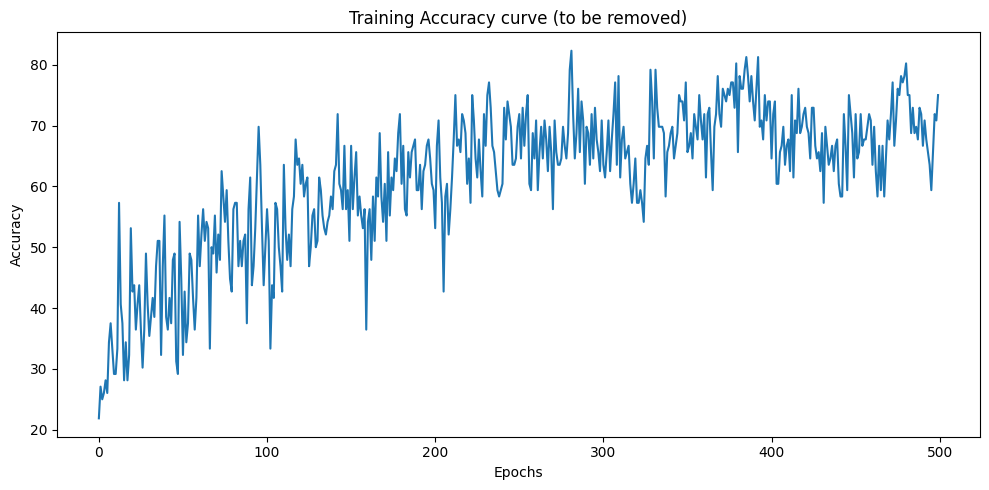

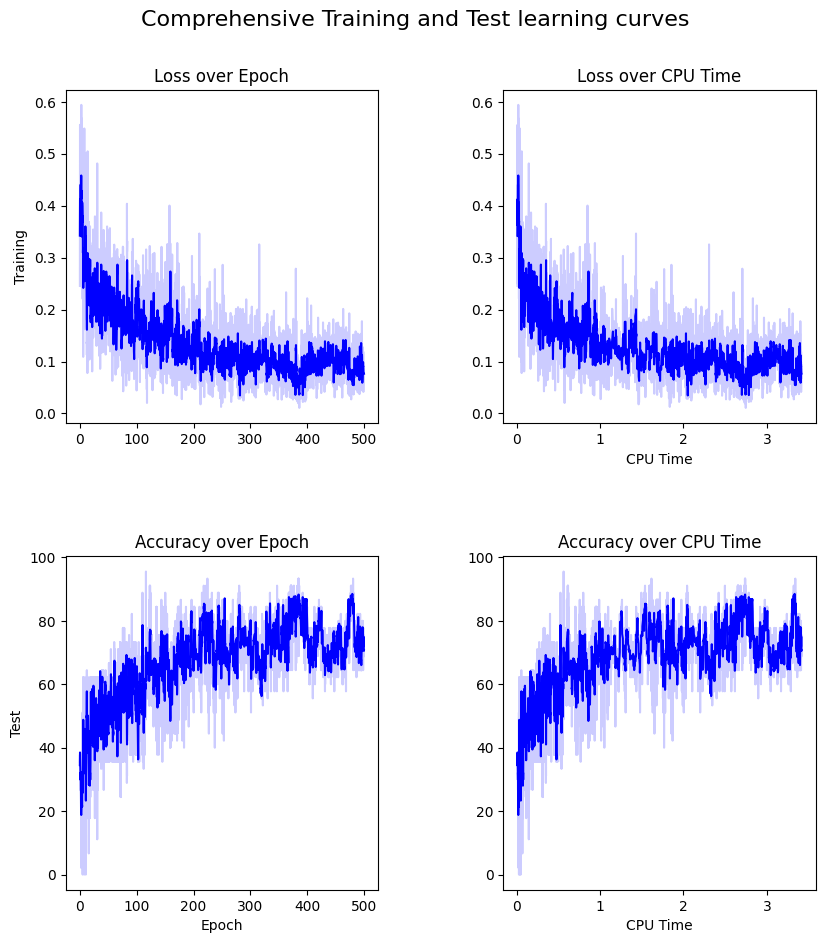

In [5]:
SFW_iris = SFW_NN(X_train, y_train, X_test, y_test, initfactor = 20)
SFW_iris.train()
SFW_iris.test()
SFW_iris.plot_learning_curves()

In [6]:
SFW_iris.plot_2D_update()

### 2.1.2 AdaSFW


 W1 radius 4.85071250072666
 W2 radius 4.886777774252209
W1: (4, 64)
W2: (64, 3)
Time 0.05183s, Epoch 1:             Loss = 0.12377714518050707,            Accuracy = 61.45833333333333%
Time 0.08255s, Epoch 2:             Loss = 0.039229254445659965,            Accuracy = 82.29166666666666%
Time 0.10199s, Epoch 3:             Loss = 0.05461749722365387,            Accuracy = 75.00000000000001%
Time 0.12043s, Epoch 4:             Loss = 0.01879180037899595,            Accuracy = 84.37500000000001%
Time 0.14805s, Epoch 5:             Loss = 0.0344815728051774,            Accuracy = 81.25%
Time 0.17745s, Epoch 6:             Loss = 0.03033517013387973,            Accuracy = 81.25%
Time 0.21998s, Epoch 7:             Loss = 0.014391629446156072,            Accuracy = 83.33333333333333%
Time 0.23887s, Epoch 8:             Loss = 0.010377304459650937,            Accuracy = 85.41666666666666%
Time 0.27018s, Epoch 9:             Loss = 0.03086487916139244,            Accuracy = 82.291666666666

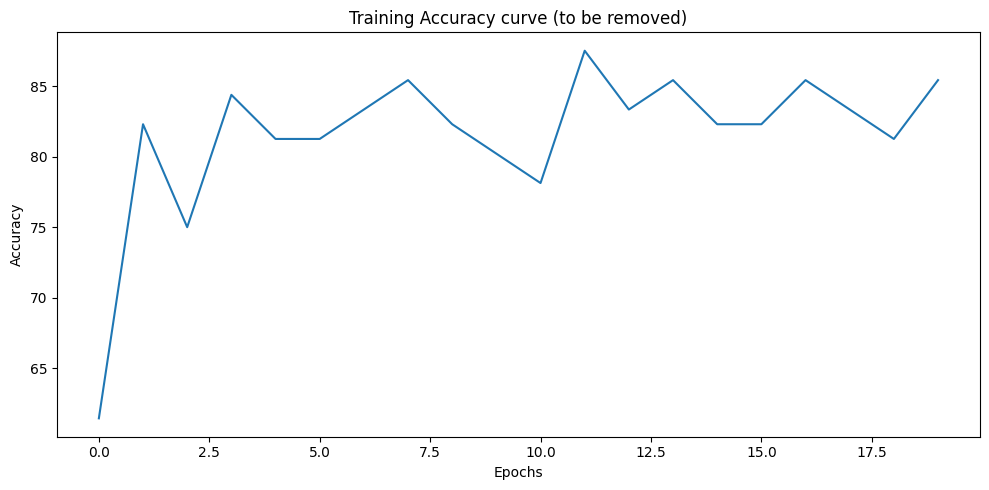

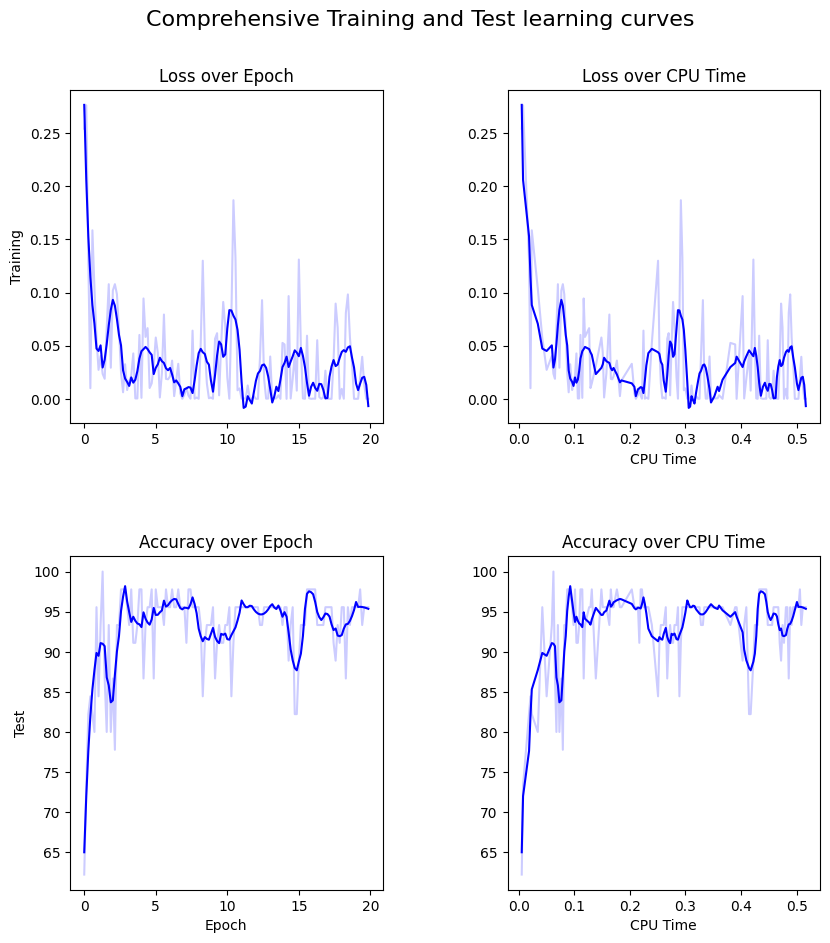

In [7]:
AdaSFW_iris = AdaSFW_NN(X_train, y_train, X_test, y_test, initfactor = 20)
AdaSFW_iris.train()
AdaSFW_iris.test()
AdaSFW_iris.plot_learning_curves()

In [8]:
AdaSFW_iris.plot_2D_update()

### 2.1.3 AdaSVRF

 W1 radius 4.85071250072666
 W2 radius 4.886777774252209
W1: (4, 64)
W2: (64, 3)
Time 0.03370s, Epoch 1:             Loss = 0.12967647275017058,            Accuracy = 61.60714285714286%
Time 0.06322s, Epoch 2:             Loss = 0.14193003238061402,            Accuracy = 65.08928571428572%
Time 0.10660s, Epoch 3:             Loss = 0.05091191890161711,            Accuracy = 80.95238095238095%
Time 0.12856s, Epoch 4:             Loss = 0.01011233112551491,            Accuracy = 86.42857142857143%
Time 0.16084s, Epoch 5:             Loss = 0.010650981158604989,            Accuracy = 85.38690476190477%
Time 0.18232s, Epoch 6:             Loss = 0.005554514837385273,            Accuracy = 86.42857142857143%
Time 0.20515s, Epoch 7:             Loss = 0.013268073265756405,            Accuracy = 85.38690476190477%
Time 0.23150s, Epoch 8:             Loss = 0.015558984697466973,            Accuracy = 84.3452380952381%
Time 0.25264s, Epoch 9:             Loss = 0.007047473609959923,            

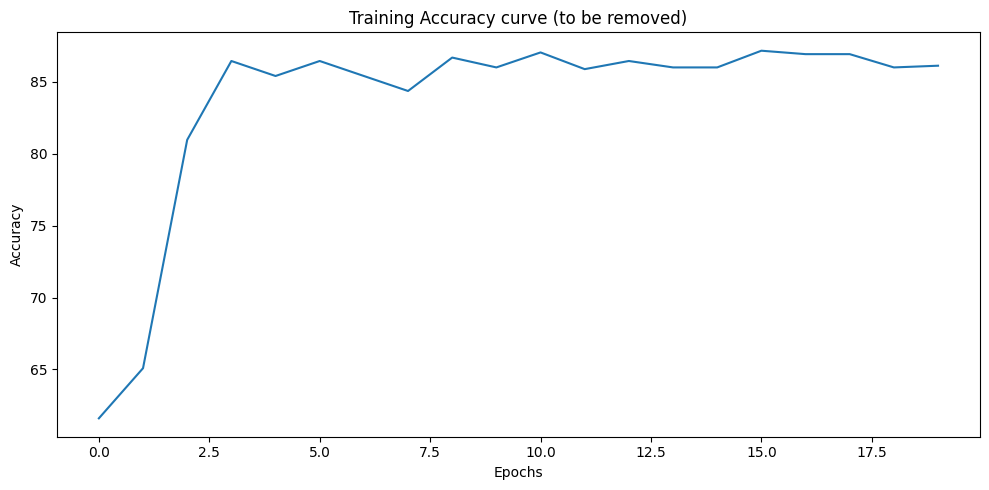

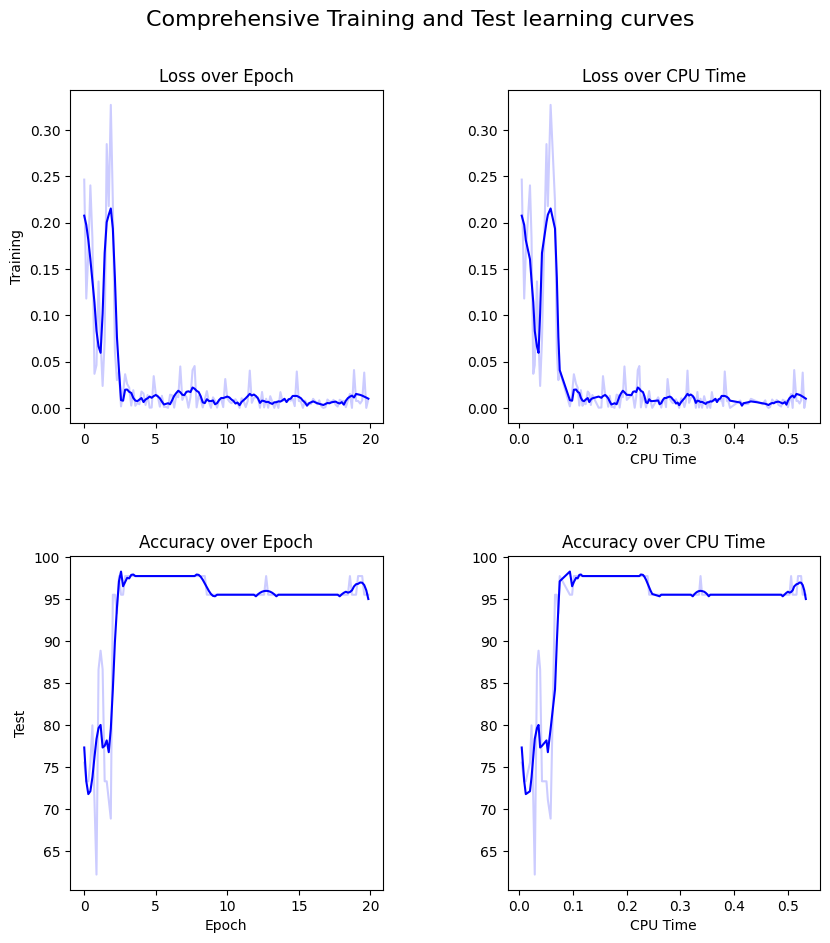

In [9]:
AdaSVRF_iris = AdaSVRF_NN(X_train, y_train, X_test, y_test, initfactor = 20, nu = 10**(-1/2), K = 5)
AdaSVRF_iris.train()
AdaSVRF_iris.test()
AdaSVRF_iris.plot_learning_curves()

In [10]:
AdaSVRF_iris.plot_2D_update()

## 2.2 Obesity Dataset


This dataset contains information about the obesity classification of individuals. The data was collected from a variety of sources, including medical records, surveys, and self-reported data. The dataset includes the following columns:

ID: A unique identifier for each individual \\
Age: The age of the individual \\
Gender: The gender of the individual \\
Height: The height of the individual in centimeters \\
Weight: The weight of the individual in kilograms \\
BMI: The body mass index of the individual, calculated as weight divided by height squared \\
Label: The obesity classification of the individual, which can be one of the following:
* Normal Weight
* Overweight
* Obese
* Underweight

110 samples that can be found in https://www.kaggle.com/datasets/sujithmandala/obesity-classification-dataset.

In [11]:
!gdown 1Rut46dX0xY9yqWRk1sqFGG8vRdTMdd8R

Downloading...
From: https://drive.google.com/uc?id=1Rut46dX0xY9yqWRk1sqFGG8vRdTMdd8R
To: /content/Obesity Classification.csv
100% 3.96k/3.96k [00:00<00:00, 12.3MB/s]


In [12]:
import pandas as pd

# Load the CSV data into a DataFrame usin Pandas
ob_data = pd.read_csv('/content/Obesity Classification.csv', index_col='ID')

# Display the first few rows of the DataFrame
print(ob_data.head())


    Age  Gender  Height  Weight   BMI          Label
ID                                                  
1    25    Male     175      80  25.3  Normal Weight
2    30  Female     160      60  22.5  Normal Weight
3    35    Male     180      90  27.3     Overweight
4    40  Female     150      50  20.0    Underweight
5    45    Male     190     100  31.2          Obese


In [13]:
# Check any missing values
print("There are {} missing values (NA) in the DataFrame".
      format(ob_data.isnull().sum().sum()))

There are 0 missing values (NA) in the DataFrame


In [14]:
# Feature encoding of the "Gender" attribute
ob_data.Gender = ob_data.Gender.map(lambda x: 1 if x=='Male' else -1)
print(ob_data.head())

    Age  Gender  Height  Weight   BMI          Label
ID                                                  
1    25       1     175      80  25.3  Normal Weight
2    30      -1     160      60  22.5  Normal Weight
3    35       1     180      90  27.3     Overweight
4    40      -1     150      50  20.0    Underweight
5    45       1     190     100  31.2          Obese


In [15]:
# Check the suggested charts
ob_data

,Age,Gender,Height,Weight,BMI,Label
ID,,,,,,
1,25,1,175,80,25.3,Normal Weight
2,30,-1,160,60,22.5,Normal Weight
3,35,1,180,90,27.3,Overweight
4,40,-1,150,50,20.0,Underweight
5,45,1,190,100,31.2,Obese
...,...,...,...,...,...,...
106,11,1,175,10,3.9,Underweight
107,16,-1,160,10,3.9,Underweight
108,21,1,180,15,5.6,Underweight


In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = ob_data.iloc[:,:-1].values
y = ob_data.iloc[:,-1].values

num_classes = len(set(y)) # Number of classification labels

# Binarize the outputs
y = LabelBinarizer().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2.2.1 SFW:

 W1 radius 4.815434123430768
 W2 radius 4.85071250072666
W1: (5, 64)
W2: (64, 4)
Time 0.01449s, Epoch 1:             Loss = 0.16339401137784232,            Accuracy = 20.833333333333332%
Time 0.01940s, Epoch 2:             Loss = 0.23123089125413387,            Accuracy = 27.777777777777775%
Time 0.02411s, Epoch 3:             Loss = 0.2508223274806857,            Accuracy = 22.222222222222218%
Time 0.04885s, Epoch 4:             Loss = 0.23969463755461176,            Accuracy = 16.666666666666668%
Time 0.06066s, Epoch 5:             Loss = 0.20115911223069569,            Accuracy = 30.555555555555557%
Time 0.06868s, Epoch 6:             Loss = 0.19833376054986487,            Accuracy = 30.555555555555557%
Time 0.07865s, Epoch 7:             Loss = 0.15432646160074592,            Accuracy = 41.666666666666664%
Time 0.09196s, Epoch 8:             Loss = 0.17763625091775792,            Accuracy = 33.333333333333336%
Time 0.09880s, Epoch 9:             Loss = 0.21177618112637916,         

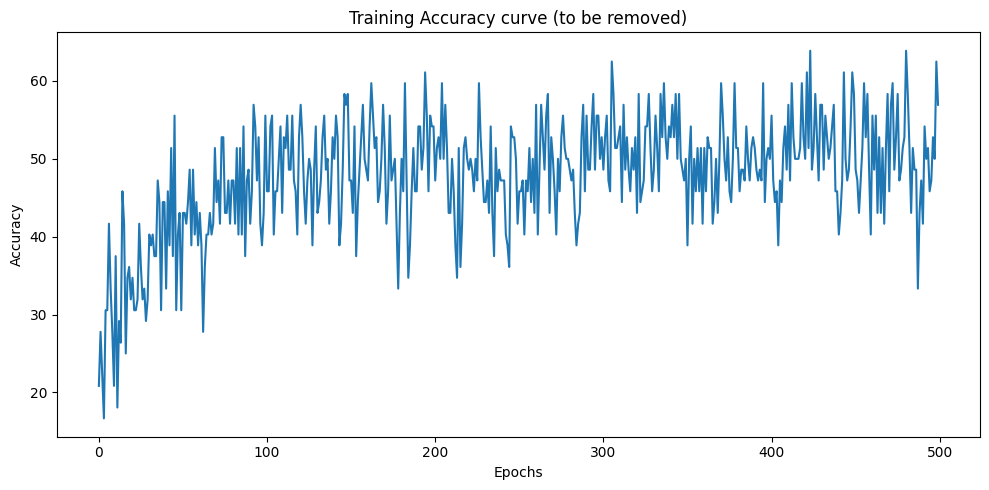

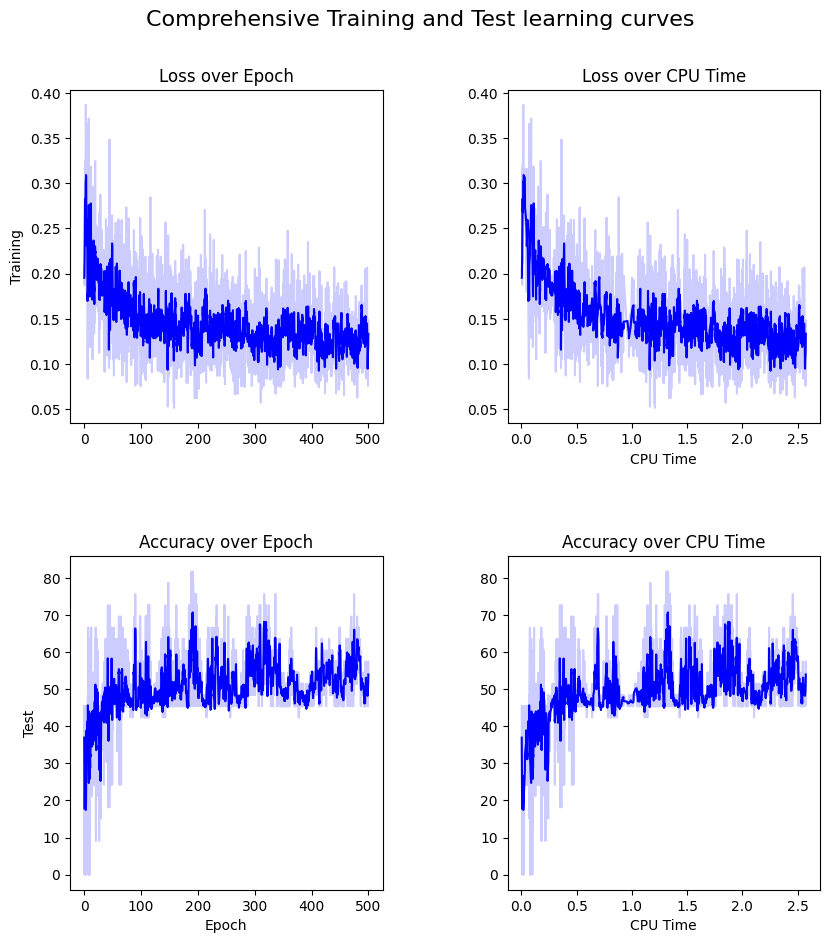

In [17]:
SFW_obesity = SFW_NN(X_train, y_train, X_test, y_test, initfactor = 20)
SFW_obesity.train()
SFW_obesity.test()
SFW_obesity.plot_learning_curves()

In [18]:
SFW_obesity.plot_2D_update()

### 2.2.2 AdaSFW


 W1 radius 4.815434123430768
 W2 radius 4.85071250072666
W1: (5, 64)
W2: (64, 4)
Time 0.01813s, Epoch 1:             Loss = 0.16105634058051618,            Accuracy = 37.5%
Time 0.03422s, Epoch 2:             Loss = 0.06732738436725007,            Accuracy = 66.66666666666667%
Time 0.04973s, Epoch 3:             Loss = 0.05828799747949296,            Accuracy = 68.05555555555556%
Time 0.06507s, Epoch 4:             Loss = 0.05368793307227646,            Accuracy = 68.05555555555556%
Time 0.08132s, Epoch 5:             Loss = 0.031680281091643274,            Accuracy = 73.61111111111111%
Time 0.09779s, Epoch 6:             Loss = 0.03364409075649149,            Accuracy = 73.6111111111111%
Time 0.11472s, Epoch 7:             Loss = 0.0333781261427064,            Accuracy = 75.0%
Time 0.13320s, Epoch 8:             Loss = 0.02102215602098718,            Accuracy = 77.77777777777777%
Time 0.15957s, Epoch 9:             Loss = 0.029510029007180628,            Accuracy = 75.0%
Time 0.17355s

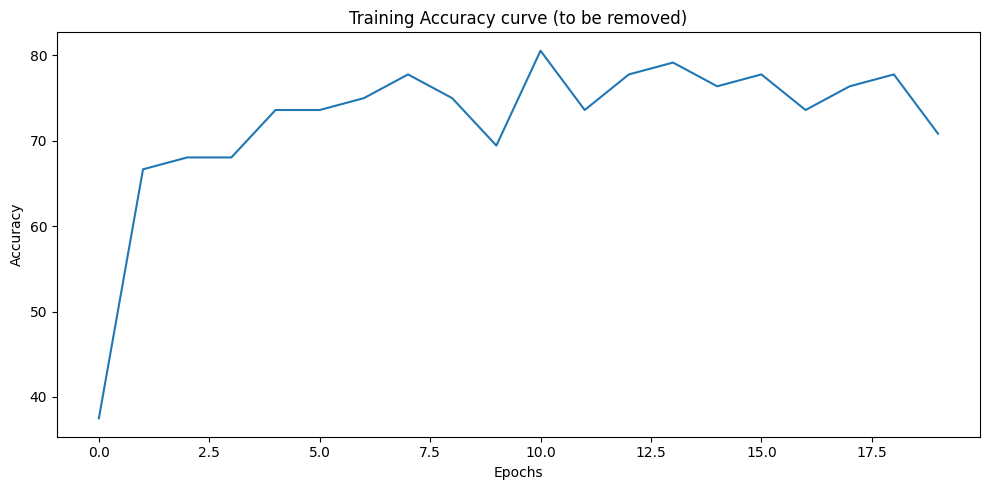

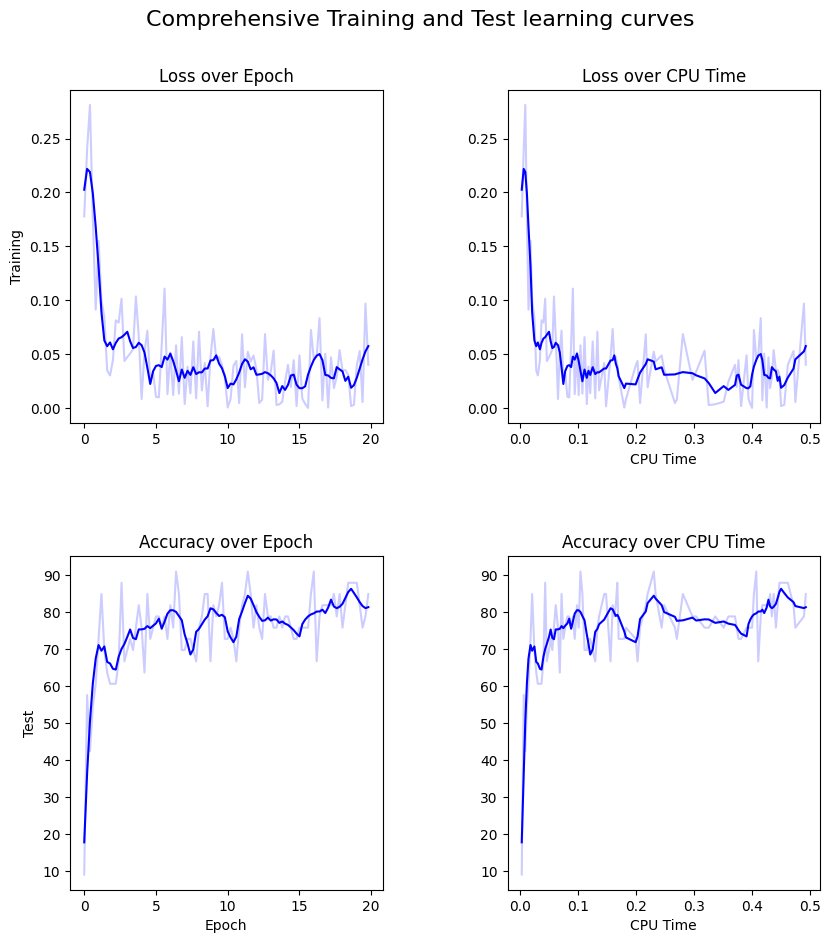

In [19]:
AdaSFW_obesity = AdaSFW_NN(X_train, y_train, X_test, y_test, initfactor = 20)
AdaSFW_obesity.train()
AdaSFW_obesity.test()
AdaSFW_obesity.plot_learning_curves()

In [20]:
AdaSFW_obesity.plot_2D_update()

### 2.2.3 AdaSVRF

 W1 radius 4.815434123430768
 W2 radius 4.85071250072666
W1: (5, 64)
W2: (64, 4)
Time 0.04373s, Epoch 1:             Loss = 0.12866297856197817,            Accuracy = 39.22222222222222%
Time 0.06487s, Epoch 2:             Loss = 0.1323116404328069,            Accuracy = 48.77777777777777%
Time 0.08128s, Epoch 3:             Loss = 0.05728277252800807,            Accuracy = 66.44444444444444%
Time 0.09749s, Epoch 4:             Loss = 0.04503356362751971,            Accuracy = 71.38888888888889%
Time 0.12124s, Epoch 5:             Loss = 0.02859784259556822,            Accuracy = 76.61111111111111%
Time 0.15258s, Epoch 6:             Loss = 0.032865553608008795,            Accuracy = 74.55555555555556%
Time 0.18367s, Epoch 7:             Loss = 0.022605378154101134,            Accuracy = 76.1111111111111%
Time 0.22102s, Epoch 8:             Loss = 0.01434479351052211,            Accuracy = 79.94444444444444%
Time 0.23694s, Epoch 9:             Loss = 0.012465293002598568,            Acc

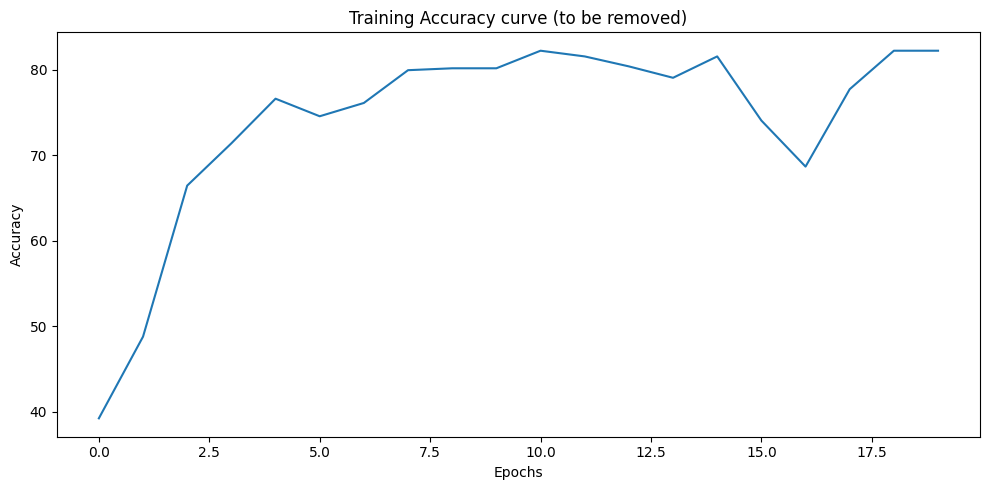

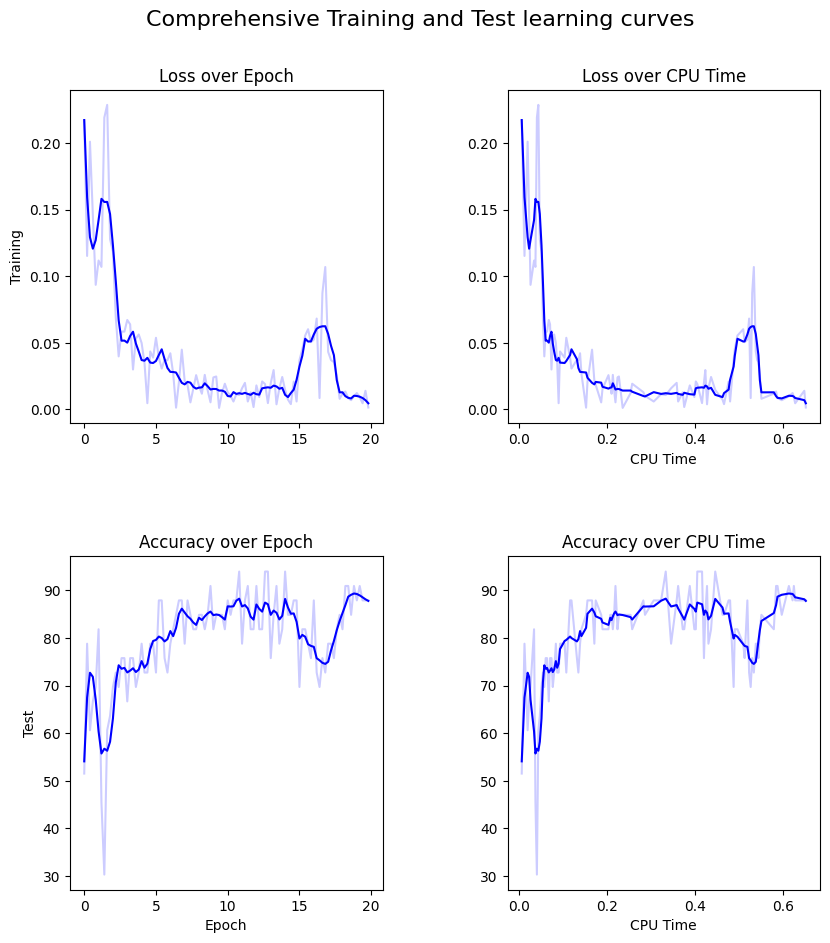

In [21]:
AdaSVRF_obesity = AdaSVRF_NN(X_train, y_train, X_test, y_test, initfactor = 20, nu = 10**(-1/2), K = 5)
AdaSVRF_obesity.train()
AdaSVRF_obesity.test()
AdaSVRF_obesity.plot_learning_curves()

In [22]:
AdaSVRF_obesity.plot_2D_update()

# 3. Final results

In [23]:
def plot_learning_curves(nns, MAX_EPOCHS = 100, MAX_CPU_TIME = 2):
    col = 0
    colors = ["c", "m", "y", "orange"]
    from scipy.signal import savgol_filter

    # Create subplots
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for nn in nns:
        '''Plots the learning curves for loss and accuracy over epochs'''

        #### Plot comprehensive curves

        # Define the color for the curves
        curve_color = colors[col]

        # CUT data to MAX_EPOCHS and MAX_CPU_TIME
        indices = np.where(np.asarray(nn.epoch_decimal) > MAX_EPOCHS)
        # Get the first index
        if len(indices[0]) > 0:
            CUT_EPOCHS = indices[0][0]
        else:
            CUT_EPOCHS = len(nn.epoch_decimal)

        indices = np.where(np.asarray(nn.cpu_time) > MAX_CPU_TIME)
        # Get the first index
        if len(indices[0]) > 0:
            CUT_CPU = indices[0][0]
        else:
            CUT_CPU = len(nn.epoch_decimal)

        # Plot loss over epochs
        ax[0, 0].plot(nn.epoch_decimal[:CUT_EPOCHS], nn.loss_history[:CUT_EPOCHS], label='Loss', alpha=0.2, color=curve_color)
        smoothed_loss = savgol_filter(nn.loss_history, window_length=50, polyorder=3)
        ax[0, 0].plot(nn.epoch_decimal[:CUT_EPOCHS], smoothed_loss[:CUT_EPOCHS], label='Smoothed Loss', color=curve_color)
        ax[0, 0].set_ylabel("Training")

        print(np.shape(nn.epoch_decimal))
        print(CUT_EPOCHS)
        print(np.shape(nn.loss_history))
        # Plot loss over CPU time
        ax[0, 1].plot(nn.cpu_time[:CUT_CPU], nn.loss_history[:CUT_CPU], label='Loss', alpha=0.2, color=curve_color)
        ax[0, 1].plot(nn.cpu_time[:CUT_CPU], smoothed_loss[:CUT_CPU], label='Smoothed Loss', color=curve_color)
        ax[0, 1].set_xlabel("CPU Time")

        # Plot accuracy over epochs
        ax[1, 0].plot(nn.epoch_decimal[:CUT_EPOCHS], nn.test_accuracy_history[:CUT_EPOCHS], label='Accuracy', alpha=0.2, color=curve_color)
        smoothed_accuracy = savgol_filter(nn.test_accuracy_history, window_length=50, polyorder=3)
        ax[1, 0].plot(nn.epoch_decimal[:CUT_EPOCHS], smoothed_accuracy[:CUT_EPOCHS], label='Smoothed Accuracy', color=curve_color)
        ax[1, 0].set_xlabel("Epoch")
        ax[1, 0].set_ylabel("Test")

        # Plot accuracy over CPU time
        ax[1, 1].plot(nn.cpu_time[:CUT_CPU], nn.test_accuracy_history[:CUT_CPU], label='Accuracy', alpha=0.2, color=curve_color)
        ax[1, 1].plot(nn.cpu_time[:CUT_CPU], smoothed_accuracy[:CUT_CPU], label='Smoothed Accuracy', color=curve_color)
        ax[1, 1].set_xlabel("CPU Time")

        plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
        col = col + 1


    ax[0, 0].set_title("Loss over Epoch")
    ax[0, 1].set_title("Loss over CPU Time")
    ax[1, 0].set_title("Accuracy over Epoch")
    ax[1, 1].set_title("Accuracy over CPU Time")

    # Create custom legend lines
    from matplotlib.lines import Line2D  #
    legend_lines = [Line2D([0], [0], color=colors[i], lw=2, label=type(nns[i]).__name__.split("_")[0]) for i in range(col)]

    # Set a single legend on the side using the custom lines
    fig.legend(handles=legend_lines, loc='center', prop={'size': 16})




    plt.show()

(3500,)
141
(3500,)
(140,)
140
(140,)


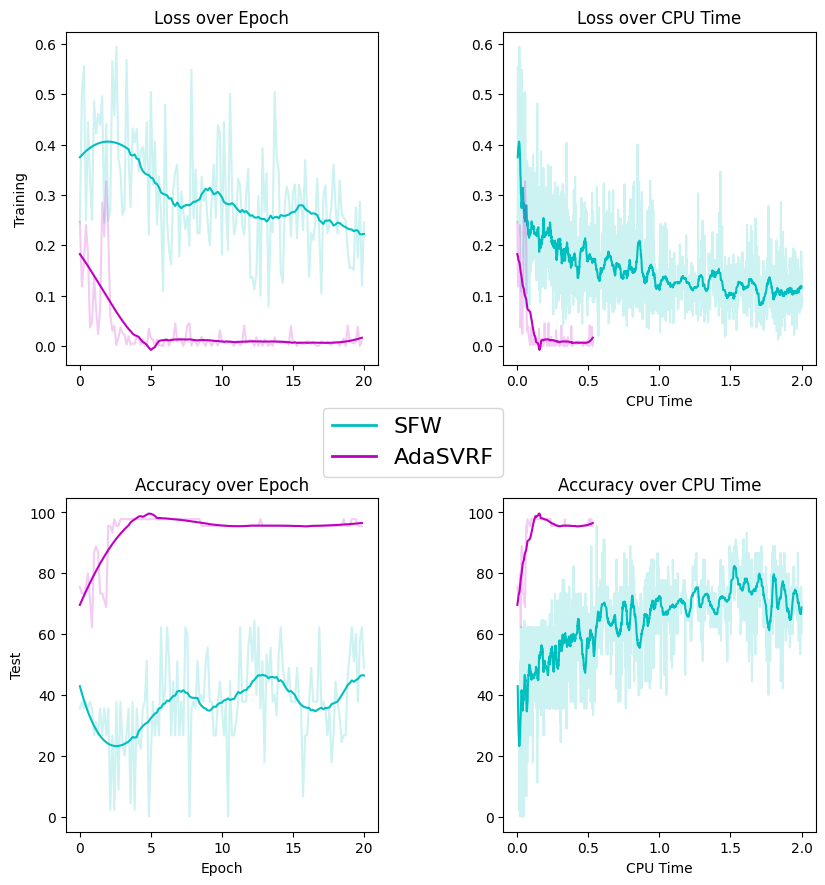

In [24]:
plot_learning_curves([SFW_iris, AdaSVRF_iris], MAX_EPOCHS = 20, MAX_CPU_TIME = 2)

(2500,)
101
(2500,)
(100,)
100
(100,)


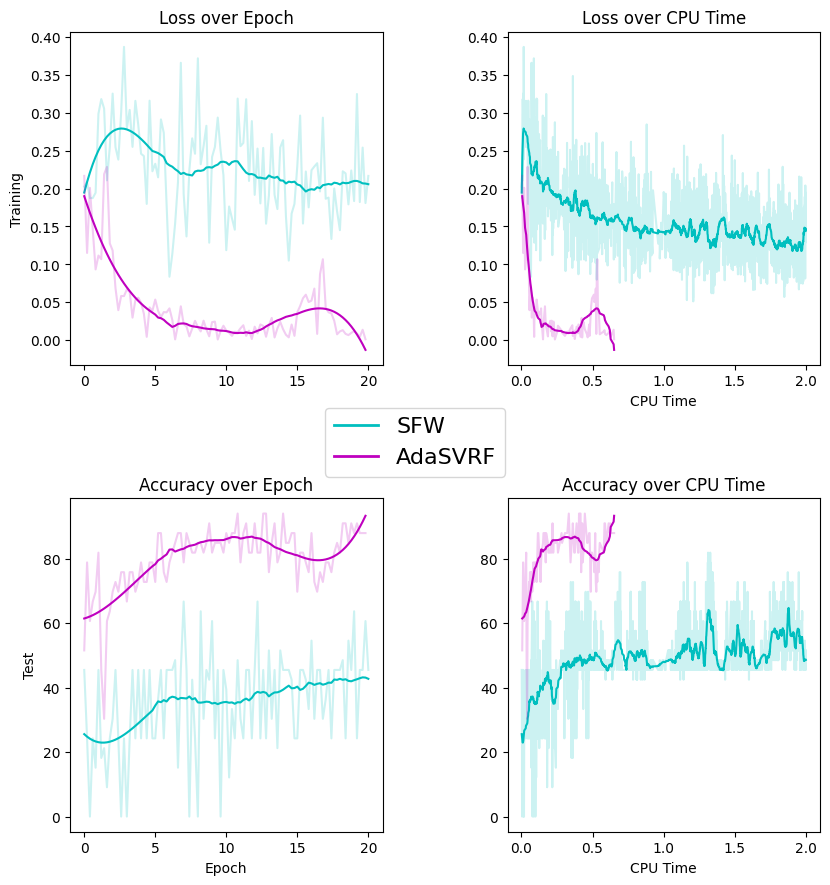

In [25]:
plot_learning_curves([SFW_obesity, AdaSVRF_obesity], MAX_EPOCHS = 20, MAX_CPU_TIME = 2)